In [1]:
# Restart the kernel
import os
import dill as pickle
current_dir ='../../../'
os.chdir(current_dir)

In [ ]:
from src.codes.basic import *
from src.codes.utils.fem_utils import *
from src.codes.utils.plot_utils import OneDPlot as plot
from src.codes.utils.rom_utils import *

In [3]:
from src.codes.prob_classes.base_class_heat_conduction import FOS_FEM
from src.codes.prob_classes.base_class_heat_conduction import probdata

import src.codes.reductor.rom_class as rom_class
import src.codes.algorithms.deim_test as deim_module
from importlib import reload
reload(deim_module)

<module 'src.codes.algorithms.deim_test' from 'd:\\D\\ONEDRIVE\\OneDrive - Texas A&M University\\TAMU_MATERIALS\\POSTDOC\\HYPERREDUCTION\\SUPARNO\\Hyperreduction_tamids\\pyHyperRom\\src\\codes\\algorithms\\deim_test.py'>

In [4]:
filename_dataC = 'examples/heat_conduction/1D_heat_conduction/DataClass.dill'      
filename_params_list = 'examples/heat_conduction/1D_heat_conduction/params_list.npy'
filename_solutions = 'examples/heat_conduction/1D_heat_conduction/NL_solutions.npy'

In [5]:
with open(filename_dataC, 'rb') as f:
    d = pickle.load(f)

In [6]:
NLS = np.load(filename_solutions)
param_list = np.load(filename_params_list)
N_snap,_ = np.shape(NLS)

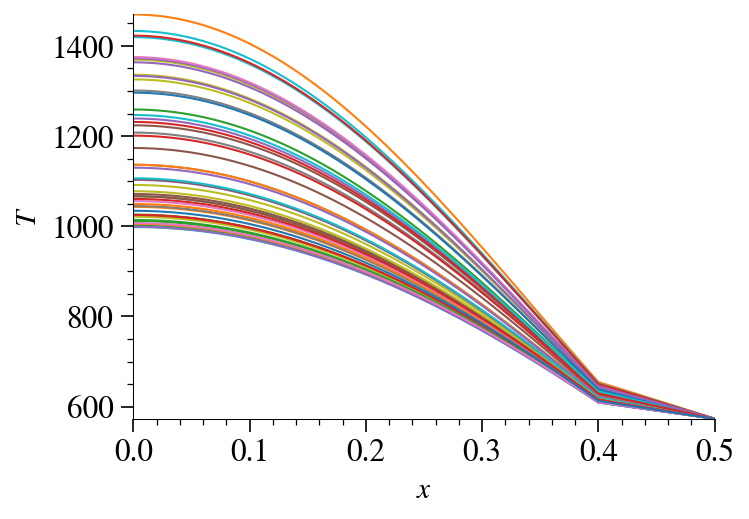

In [8]:
fig, ax = plt.subplots(figsize=(5,3.5))
plt.rcParams['figure.dpi'] = 150

for i in range(N_snap):
    Plot = plot(d.xi[0], NLS[i], ax=ax)
    Plot.line_()
plt.show()

### DEIM Hyper-reduction


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

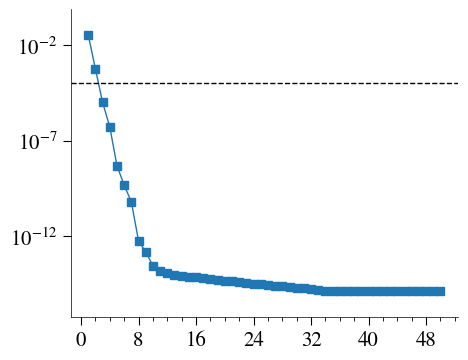

Number of modes selected: 3


In [22]:
plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS, tolerance=1e-4,modes=True)
V_sel = U[:, :n_sel]

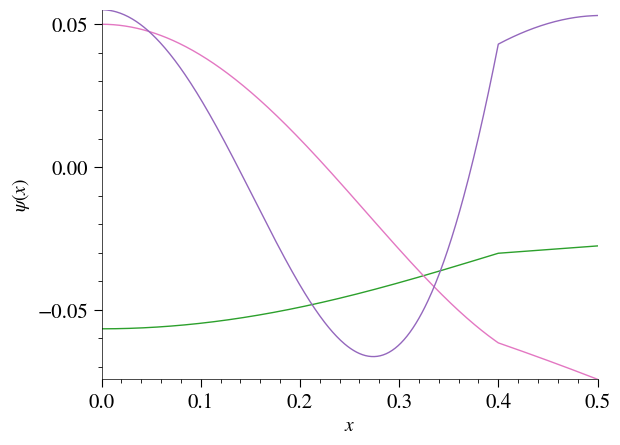

In [23]:
fig, ax = plt.subplots()

for i in range(n_sel):
    Plot = plot(d.xi[0], V_sel[:,i], ax=ax)
    Plot.line_()
    
Plot.ax.set_xlabel('$x$')
Plot.ax.set_ylabel('$\psi(x)$')

plt.show()

### Step 2: Perform SVD on the force snapshots

In [24]:
quad_deg = 3
FOS = FOS_FEM(d, quad_deg)
deim = deim_module.deim(FOS,param_list,V_sel,NLS,d.mask,tol_f=5e-14)

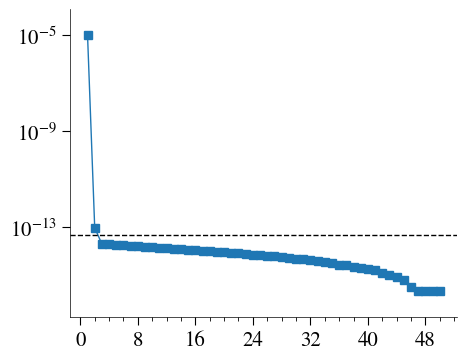

Number of modes selected: 3


In [25]:
tic_h_setup_b = time.time()
deim.select_elems()
toc_h_setup_b = time.time()
xi = deim.xi

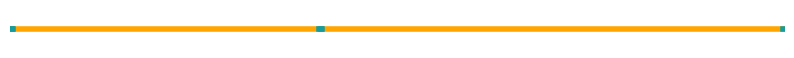

Fraction of total elements active in the ROM: 1.2%


In [26]:
plot(np.arange(d.ncells[0]), xi, ax="").element_()
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")


### ROM Simulation

In [28]:
params = np.arange(1., 4.0, 0.01)
params_rm = params[~np.isin(params,param_list)]
param_rom = random.choice(params_rm)

In [30]:
bc = {
    'x_min': {'type': 'refl', 'value': np.nan},
    'x_max': {'type': 'dirichlet', 'value': 273.15 + 300}
}

In [31]:
# Define the data-class
d_test = probdata(bc, mat_layout, src_layout, fdict, n_ref, L, param_rom, pb_dim=1)
FOS_test = FOS_FEM(d_test,quad_deg)
ROM_h = rom_class.rom_deim(d_test, deim, quad_deg)
ROM = rom_class.rom(d_test, quad_deg)

NameError: name 'mat_layout' is not defined

In [ ]:
# Initial guess
T_init_fos = np.zeros(FOS_test.n_nodes) + 273.15
T_init_rom = np.transpose(V_sel)@T_init_fos # crucial to ensure the initial guess is contained in the reduced subspace

In [ ]:
# Time taken to perform a FO simulation with the current parameter value

tic_fos = time.time()
NL_solution_fos_test, _, _, _, = solve_fos(FOS_test,T_init_fos)
NL_solution_fos_test = NL_solution_fos_test.flatten()
toc_fos = time.time()

In [ ]:
# Time taken to simulate a ROM without hyper-reduction

tic_rom_woh = time.time()
NL_solution_reduced_woh = ROM.solve_rom(T_init_rom,V_sel)
sol_red_woh = np.dot(V_sel,NL_solution_reduced_woh) #full-scale
toc_rom_woh = time.time()

c:\Users\supar\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [ ]:
# Time taken to simulate a ROM *with* hyper-reduction

tic_rom = time.time()
NL_solution_reduced = ROM_h.solve_rom(T_init_rom,xi,V_sel)
sol_red = np.dot(V_sel,NL_solution_reduced)  #full-scale
toc_rom = time.time()

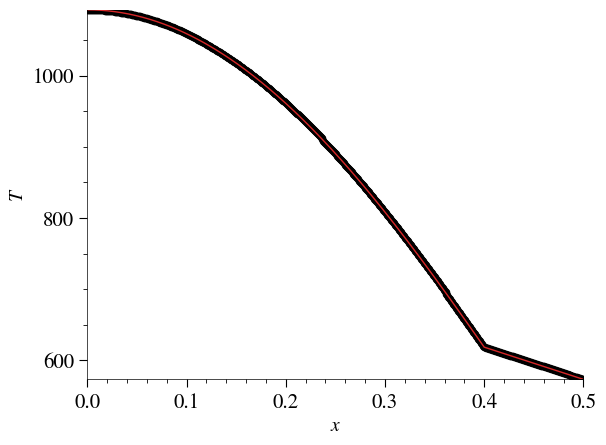

ROM error with hyperreduction: 0.010285073472216986 %


ROM error without hyperreduction: 0.0037929303611243226 %


In [ ]:
fig, ax = plt.subplots()

plot(d_test.xi[0], sol_red, ax=ax).line_()
plot(d_test.xi[0], NL_solution_fos_test, ax=ax,  clr='k', sz=20).scatter_()
plt.show()

print(f"ROM error with hyperreduction: {np.linalg.norm(sol_red-NL_solution_fos_test)*100/np.linalg.norm(NL_solution_fos_test)} %")
print(f"\n\nROM error without hyperreduction: {np.linalg.norm(sol_red_woh-NL_solution_fos_test)*100/np.linalg.norm(NL_solution_fos_test)} %")


#### Speedups

In [ ]:
fos_sim_time = toc_fos - tic_fos
rom_sim_time_woh = toc_rom_woh - tic_rom_woh
rom_sim_time = toc_rom - tic_rom

In [ ]:
print(f"speedup without hyperreduction:{fos_sim_time/rom_sim_time_woh}")
print(f"speedup with hyperreduction:{fos_sim_time/(rom_sim_time)}")
# h_total_setup_time = (toc_h_setup_b+toc_h_setup_a) - (tic_h_setup_b+tic_h_setup_a) #this is one time

speedup without hyperreduction:0.8311849032801507
speedup with hyperreduction:26.10776866884381
